# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtest.utils import run_strategy, run_wfo


from backtesting import Backtest
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random

random.seed(42)

In [3]:
initial_cash = 10_000
margin = 1/30
commission = 7e-4

In [4]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()

groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [5]:

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Stocks_group' in symbol.path]
# tickers = ['USOILm']

print(tickers)

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
date_from = datetime(2021, 10, 1, tzinfo=timezone)
date_to = datetime(2024, 9, 1, tzinfo=timezone)

intervals = [
    mt5.TIMEFRAME_H4,
]

symbols = get_data(tickers, intervals, date_from, date_to)

['AAPLm', 'ABBVm', 'ABTm', 'ADBEm', 'ADPm', 'AMDm', 'AMGNm', 'AMTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BAm', 'BABAm', 'BACm', 'BIIBm', 'BMYm', 'Cm', 'CHTRm', 'CMCSAm', 'CMEm', 'COSTm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'EQIXm', 'Fm', 'FBm', 'GILDm', 'GOOGLm', 'HDm', 'IBMm', 'INTCm', 'INTUm', 'ISRGm', 'JNJm', 'JPMm', 'KOm', 'LINm', 'LLYm', 'LMTm', 'MAm', 'MCDm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NFLXm', 'NKEm', 'NVDAm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'REGNm', 'SBUXm', 'Tm', 'TMOm', 'TMUSm', 'TSLAm', 'UNHm', 'UPSm', 'Vm', 'VRTXm', 'VZm', 'WFCm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BIDUm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'EDUm', 'FTNTm', 'FUTUm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm', 'METAm']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AAPLm
ABBVm
ABTm
ADBEm
ADPm
AMDm
AMGNm
AMTm
AMZNm
ATVIm
se descarto ATVIm
AVGOm
BAm

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

In [8]:
start_date_train = Timestamp('2023-09-01 00:00:00', tz='UTC')
limit_date_train = Timestamp('2024-09-01 00:00:00', tz='UTC')

print(start_date_train)
print(limit_date_train)

2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Analisis preliminar

In [9]:
from backtesting import Strategy
import talib as ta
from backbone.utils.general_purpose import calculate_units_size, diff_pips

class MeanReversion(Strategy):
    pip_value = None
    minimum_lot = None
    contract_volume = None
    minimum_units = None
    
    sma_period = 50
    deviation_threshold = 0.01
    risk = 1
    cum_rsi_up_threshold = 90
    cum_rsi_down_threshold = 10
    atr_multiplier = 2
    
    def init(self):
        self.sma = self.I(ta.SMA, self.data.Close, timeperiod=self.sma_period)
        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=2)
        self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close)
        
        self.minimum_units = self.minimum_lot * self.contract_volume


    def next(self):
        # Precio actual y valor de la SMA
        actual_close = self.data.Close[-1]
        sma_value = self.sma[-1]
        cum_rsi = self.rsi[-1] + self.rsi[-2]

        # Desviación del precio con respecto a la SMA (en porcentaje)
        deviation = (actual_close - sma_value) / sma_value

        if self.position:
            if self.position.is_long and actual_close >= self.sma:
                self.position.close()

            if self.position.is_short and actual_close <= self.sma:
                self.position.close()  
        
        else:
            # Condiciones para comprar (precio por debajo de la SMA más del umbral de desviación)
            if deviation <= -self.deviation_threshold and cum_rsi <= self.cum_rsi_down_threshold:
                sl_price = self.data.Close[-1] - self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value
                )
                
                if units < self.minimum_units:
                    units = self.minimum_units
                
                self.buy(
                    size=units,
                    sl=sl_price
                )

            # Condiciones para vender (precio por encima de la SMA más del umbral de desviación)
            elif deviation >= self.deviation_threshold and cum_rsi >= self.cum_rsi_up_threshold:
                sl_price = self.data.Close[-1] + self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value
                )
                
                if units < self.minimum_units:
                    units = self.minimum_units
                
                self.sell(
                    size=units,
                    sl=sl_price
                )

In [10]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression

strategies = [
    MeanReversion
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    # try:
    print(ticker, interval)

    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=7e-4, 
        prices=symbols[ticker][interval], 
        initial_cash=initial_cash, 
        margin=1/30
    )

    performance = pd.concat([performance, df_stats])

    # except:
    #     print(f'hubo un problema con {ticker} {interval}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAPLm 16388
ABBVm 16388
ABTm 16388
ADBEm 16388
ADPm 16388
AMDm 16388
AMGNm 16388
AMTm 16388
AMZNm 16388
AVGOm 16388
BABAm 16388
BACm 16388
BAm 16388
BBm 16388
BEKEm 16388
BIDUm 16388
BIIBm 16388
BILIm 16388
BMYm 16388
CHTRm 16388
CMCSAm 16388
CMEm 16388
COSTm 16388
CSCOm 16388
CSXm 16388
CVSm 16388
Cm 16388
EAm 16388
EBAYm 16388
EDUm 16388
EQIXm 16388
FBm 16388
FTNTm 16388
FUTUm 16388
Fm 16388
GILDm 16388
GOOGLm 16388
HDm 16388
IBMm 16388
INTCm 16388
INTUm 16388
IQm 16388
ISRGm 16388
JDm 16388
JNJm 16388
JPMm 16388
KOm 16388
LINm 16388
LIm 16388
LLYm 16388
LMTm 16388
MAm 16388
MCDm 16388
MDLZm 16388
METAm 16388
MMMm 16388
MOm 16388
MRKm 16388
MSFTm 16388
MSm 16388
NFLXm 16388
NIOm 16388
NKEm 16388
NTESm 16388
NVDAm 16388
ORCLm 16388
PDDm 16388
PEPm 16388
PFEm 16388
PGm 16388
PMm 16388
PYPLm 16388
REGNm 16388
RLXm 16388
SBUXm 16388
TALm 16388
TMEm 16388
TMOm 16388
TMUSm 16388
TSLAm 16388
TSMm 16388
Tm 16388
UNHm 16388
UPSm 16388
VIPSm 16388
VRTXm 16388
VZm 16388
Vm 16388
WFCm 16388
WMTm

In [11]:

filter_performance = performance[
    (performance['return/dd']>1)
    & (performance['stability_ratio']>0.8)
].sort_values(by=['return/dd'], ascending=[False])#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,UNHm,16388,0.899085,33.400224,13340.022428,5.387711,147 days 00:00:00,51.388889,1.194100,72,0.713245,63.907088,13340.022428,1038 days,6.199335,22.434064
0,MeanReversion,UPSm,16388,0.880360,27.508740,12750.873992,7.584760,329 days 20:00:00,50.000000,1.017942,82,0.756914,71.590232,12750.873992,1038 days,3.626844,14.159597
0,MeanReversion,YUMCm,16388,0.881465,18.199070,11819.906953,5.361031,196 days 20:00:00,52.238806,0.766458,67,0.664842,63.013699,11819.906953,1038 days,3.394696,12.072118
0,MeanReversion,BEKEm,16388,0.861398,24.205616,12420.561626,8.797488,307 days 20:00:00,55.833333,1.014762,120,0.840582,63.898734,12420.561626,1038 days,2.751424,11.848452
0,MeanReversion,MOm,16388,0.894778,19.897077,11989.707696,13.391293,177 days 04:00:00,43.902439,0.757831,82,0.511131,75.878499,11989.707696,1038 days,1.485822,6.109389
0,MeanReversion,AMTm,16388,0.821993,9.241588,10924.158757,7.897315,191 days 20:00:00,39.705882,0.422015,68,0.371066,67.004169,10924.158757,1038 days,1.170219,4.397941


In [18]:
# for ticker, interval in zip(portfolio, intervals):
#     bt_train = Backtest(
#         symbols[ticker][interval].loc[start_date_train:limit_date_train], 
#         MeanReversion,
#         commission=7e-4,
#         cash=initial_cash, 
#         margin=1/30
#     )

#     stats = bt_train.run(
#         pip_value = pip_value,
#         minimum_lot = minimum_lot,
#         contract_volume = contract_volume,
#         sma_period=100
#     )

#     bt_train.plot(filename=f'./plots/{ticker}.html', resample=False)

# WFO

In [13]:
from backtest.utils import optim_func_2


strategy = MeanReversion
lookback_bars = 1000
validation_bars = 100
warmup_bars = 50

all_wfo_performances = pd.DataFrame()
stats_per_symbol = {}

params = {
    'deviation_threshold': list(np.arange(0.01, 0.2, 0.01).round(2)),
    'sma_period': [50],
}

for index, row in filter_performance.iterrows():
    
    # try:
    ticker = row.ticker
    interval = row.interval
    
    print(ticker, interval)
    
    prices = symbols[ticker][interval]

    wfo_stats, df_stats = run_wfo(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        prices=prices,
        initial_cash=initial_cash,
        commission=commission,
        margin=margin,
        optim_func=optim_func_2,
        params=params,
        lookback_bars=lookback_bars,
        warmup_bars=warmup_bars,
        validation_bars=validation_bars
    )
    
    if ticker not in stats_per_symbol.keys():
        stats_per_symbol[ticker] = {}

    stats_per_symbol[ticker][interval] = wfo_stats

    all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    # except:
    #     print(f'No se pudo ejecutar para el ticker {ticker}')

all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

all_wfo_performances.sort_values(by='return/dd', ascending=False)

UNHm 16388


UPSm 16388


YUMCm 16388


BEKEm 16388


MOm 16388


AMTm 16388


,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,UNHm,16388,0.853309,18.657581,11865.758113,5.663914,80,51.428571,1.452011,35,0.667799,5.896367,11865.758113,1038 days,3.294114,10.033111
0,MeanReversion,BEKEm,16388,0.726079,12.743325,11274.332523,8.791240,128,55.000000,1.082978,60,0.923149,5.012658,11274.332523,1038 days,1.449548,5.350313
0,MeanReversion,YUMCm,16388,0.066062,0.345487,10034.548699,5.008903,226,42.105263,0.047195,19,-0.006788,5.717689,10034.548699,1038 days,0.068975,0.172242
0,MeanReversion,UPSm,16388,0.086963,0.322798,10032.279812,7.186417,342,36.666667,0.035193,30,0.145475,5.896367,10032.279812,1038 days,0.044918,0.135405
0,MeanReversion,AMTm,16388,0.673414,-4.994653,9500.534745,11.407064,305,40.000000,0.000000,30,-0.437669,5.896367,9500.534745,1038 days,-0.437856,-1.382404
0,MeanReversion,MOm,16388,0.393731,-4.906422,9509.357789,7.229535,268,29.411765,0.000000,17,-0.514865,5.896367,9509.357789,1038 days,-0.678664,-1.723230


# Montecarlo

In [16]:
filtered_wfo_performance = all_wfo_performances[
    (all_wfo_performances['stability_ratio'] > 0.7)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,UNHm,16388,0.853309,18.657581,11865.758113,5.663914,80,51.428571,1.452011,35,0.667799,5.896367,11865.758113,1038 days,3.294114,10.033111
0,MeanReversion,BEKEm,16388,0.726079,12.743325,11274.332523,8.791240,128,55.000000,1.082978,60,0.923149,5.012658,11274.332523,1038 days,1.449548,5.350313


In [17]:
# stats_per_symbol['UKOILm'][16386]['_trades']

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from backtest.utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=initial_cash, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: UNHm
Procesando ticker: BEKEm


In [20]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_UNHm,drawdown_BEKEm
count,100000.000000,100000.000000
mean,-6.687134,-6.527181
std,3.051451,2.786579
min,-29.992975,-28.836236
10%,-10.750955,-10.277504
25%,-8.201536,-7.920864
50%,-6.066053,-5.943134
75%,-4.495738,-4.516992
90%,-3.446517,-3.569766
max,-0.637763,-1.280338


,return_UNHm,return_BEKEm
count,100000.000000,100000.000000
mean,19.413886,14.895432
std,13.527367,11.335558
min,-29.037927,-27.616719
10%,2.621702,0.833543
25%,9.996796,6.996102
50%,18.712994,14.325436
75%,28.061915,22.193491
90%,37.042749,29.726796
max,95.230100,70.764773


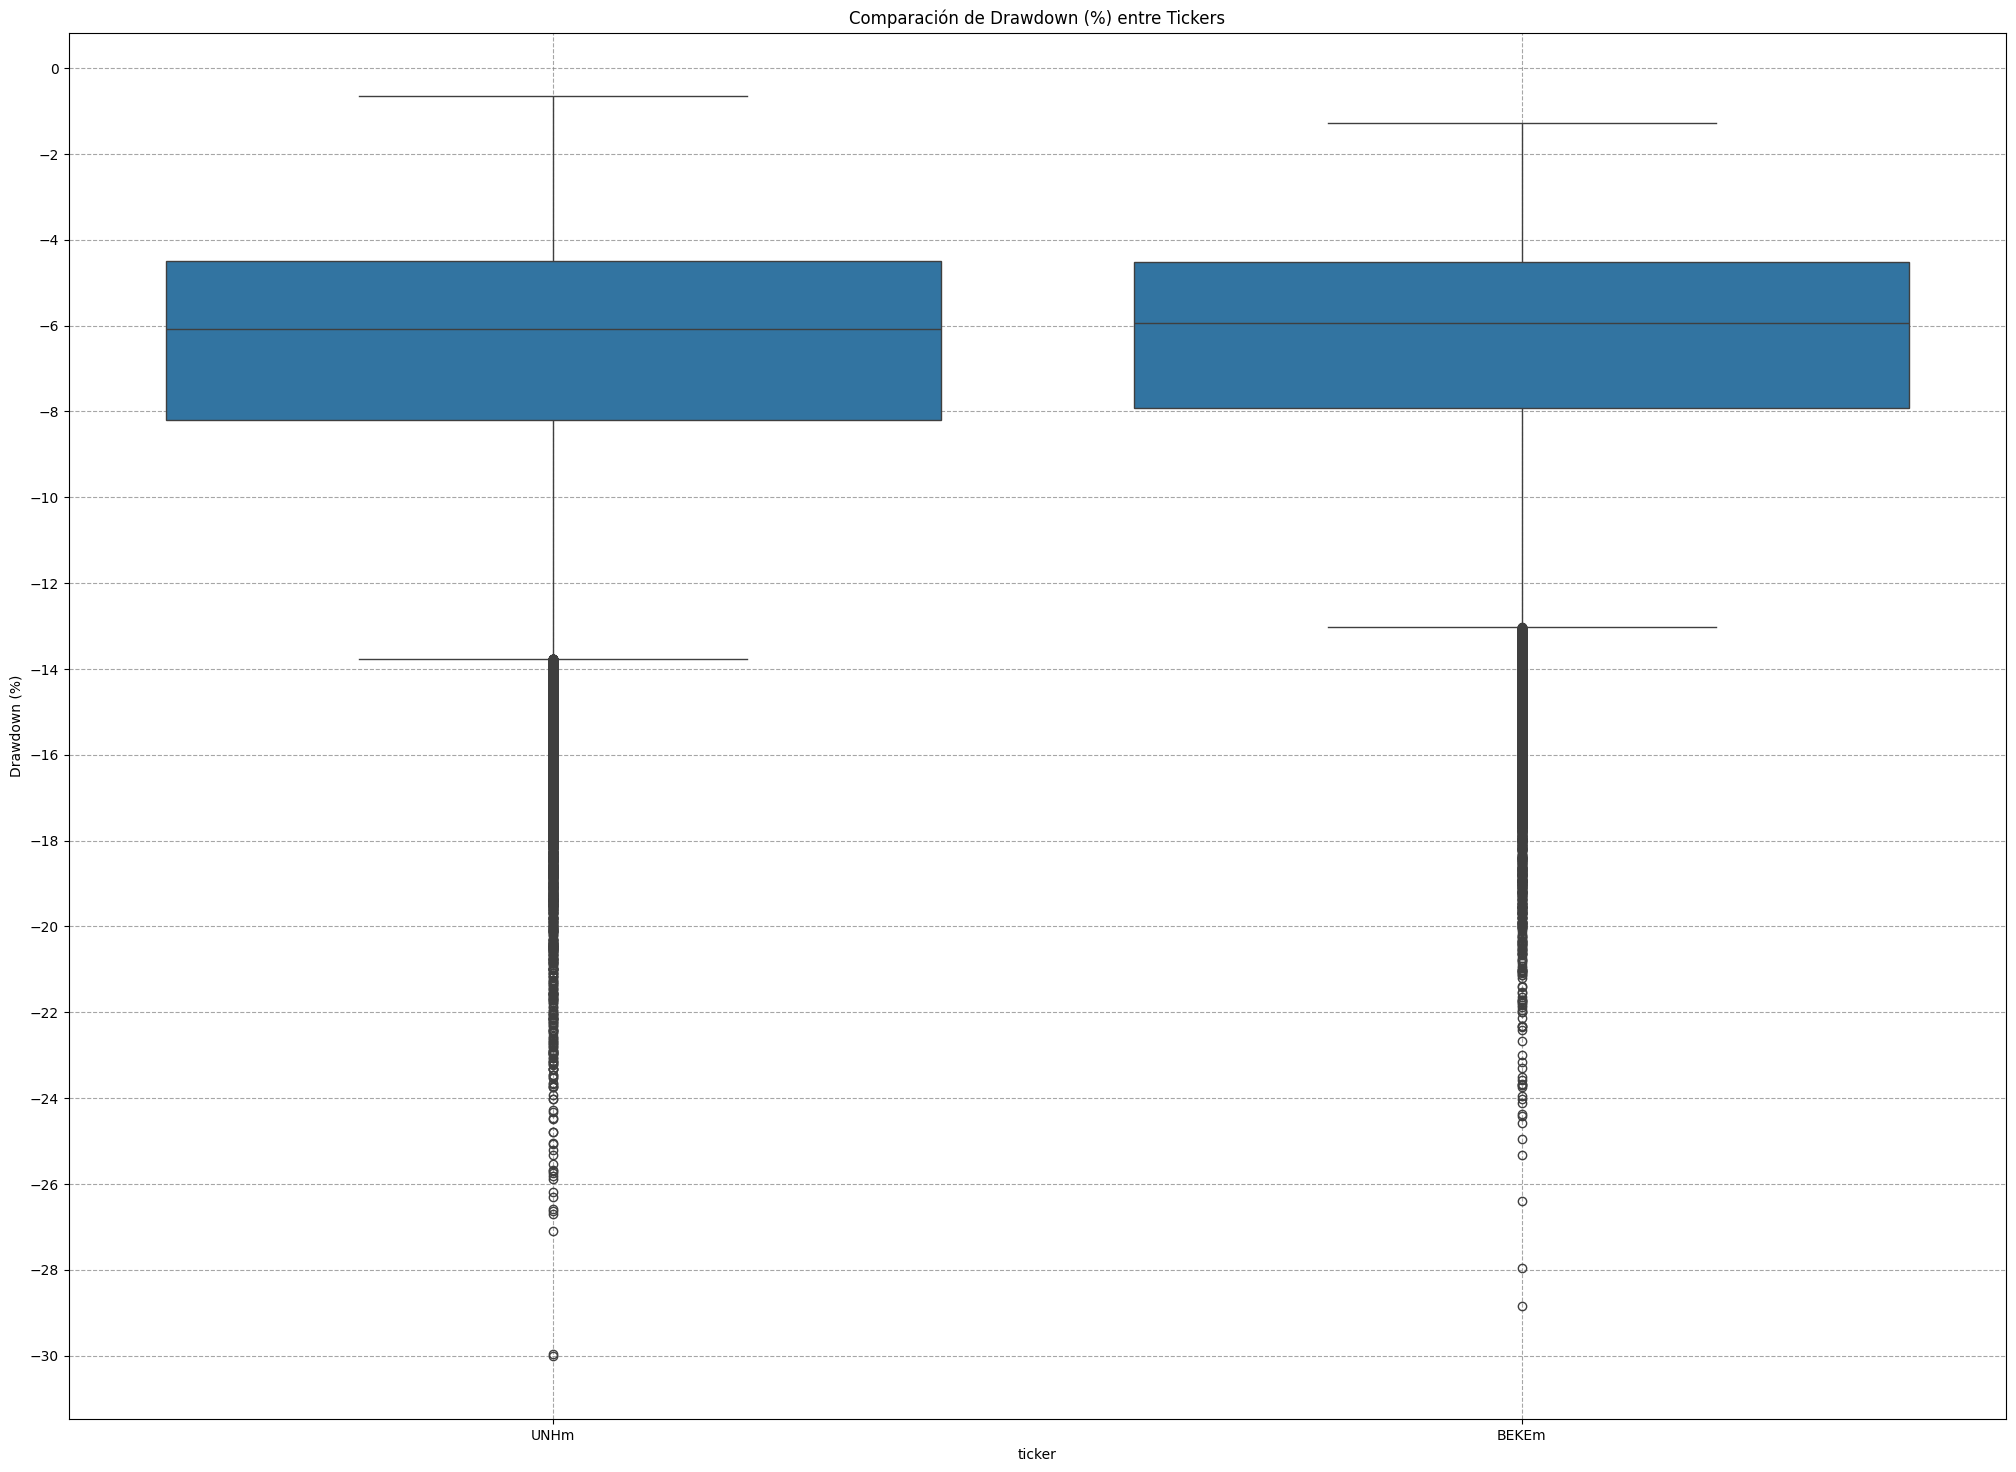

In [21]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


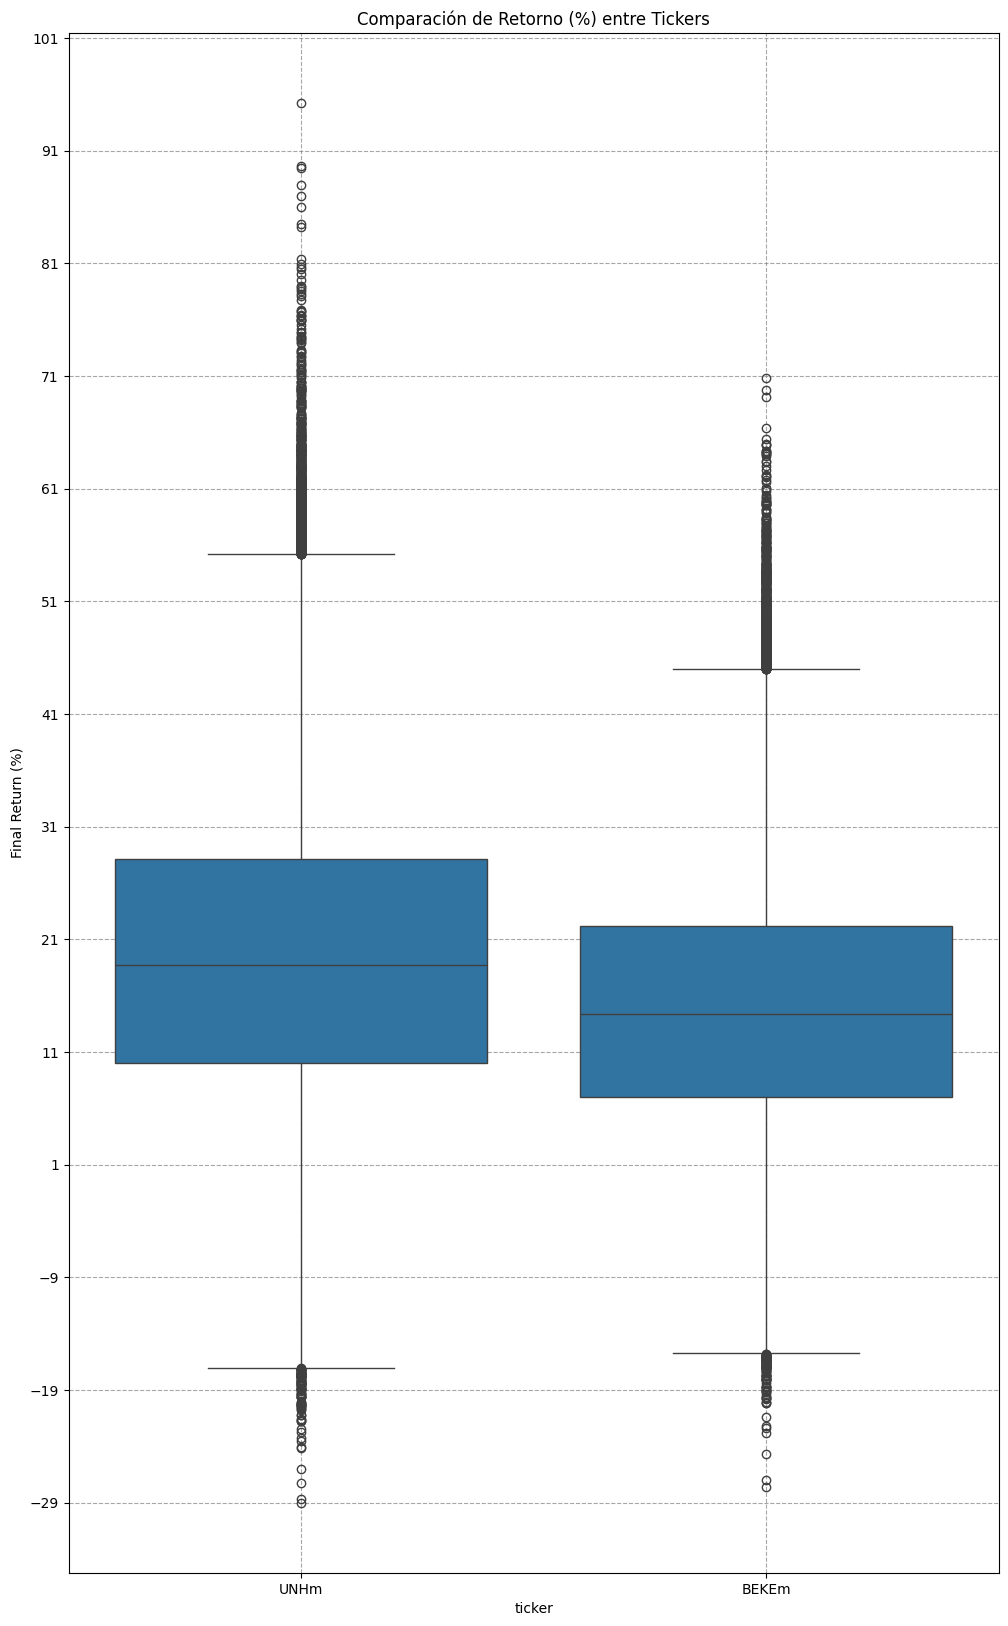

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
